In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [2]:
class data_transform:
    
    #d: the number of decimals reserved
    #n: the number of the nearest points selected around the feature point
    #path_data_file: the direction of the folder where contains the txt.
    def __init__(self, path_data_file):
        self.path_data_file = path_data_file


    
    # import all the files in the folder as dataframe, and name them as df_n
    def get_file(self):
        file_path = self.path_data_file
        augmentated_list = []
        file_list = []
        
        for i in os.listdir(file_path):
            file_list.append(os.path.join(file_path, i))

        
        names = locals()
        list_df = []

        
        for j in range(len(file_list)):
            names['df_%s'%j] = pd.read_table(file_list[j], sep='\t', skiprows=0)
            names['df_%s'%j]['Z'] = [0]*len(names['df_%s'%j])
            names['df_%s'%j]['PT'] = names['df_%s'%j]['PT'].astype(str)
            list_df.append(names['df_%s'%j])
            
        return list_df
    
    
  
    
    def generate_data(self, list_df_trans):
        point_clouds, point_cloud_labels = [],[]
        for df in tqdm(list_df_trans):
            df.H = df.H/4001
            df.V = df.V/3001
            point_cloud = df[['H', 'V', 'Z']].values
            point_clouds.append(point_cloud)
            
            label = pd.get_dummies(df.PT, drop_first=False)
            #labels = label.columns.values
            # labels_all = [str(x) for x in range(6)]
            # complementaryset = list(set(labels_all) - set(labels))

            # for PT in complementaryset:
            #     column_new = [0] * len(label)
            #     label[str(PT)] = column_new
            #     label[str(PT)] = label[str(PT)].astype(np.uint8)
                
            label = label.sort_index(axis = 1)
            label = label.values
            point_cloud_labels.append(label)
            
        return point_clouds, point_cloud_labels


In [3]:
    
    

file_path = '/Users/agustinzhang/Downloads/master_AI/TFM/Dato/Datos_pointnet/'
file_path_train = file_path+'train'
file_path_test = file_path+'test'

trans = data_transform(file_path_train)
tests = data_transform(file_path_test)
list_df_trans = trans.get_file()
list_df_trans_test = tests.get_file()

my_point_clouds, my_point_cloud_labels = trans.generate_data(list_df_trans)
my_point_clouds_test, my_point_cloud_labels_test = trans.generate_data(list_df_trans_test)

100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 1026.24it/s]


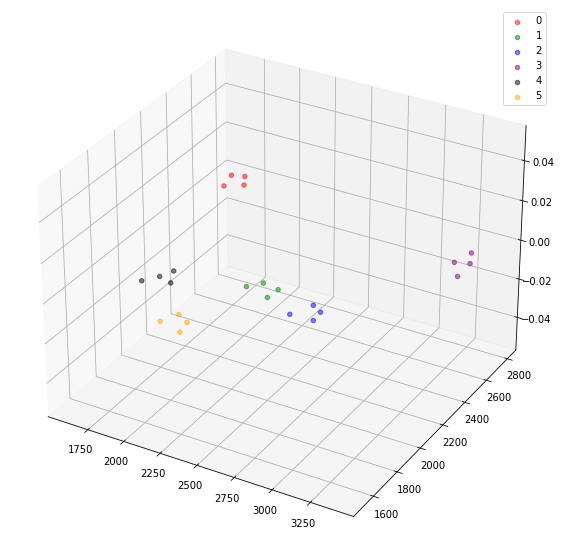

In [4]:

def visualize_data(point_cloud, labels):
    COLORS = ['red', 'green', 'blue', 'purple', 'black', 'orange']
    df = pd.DataFrame(
        data={
            "x": point_cloud[:, 0],
            "y": point_cloud[:, 1],
            "z": point_cloud[:, 2],
            "label": labels,
        }
    )
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection="3d")
    for index, label in enumerate(['0', '1', '2', '3', '4', '5']):
        c_df = df[df["label"] == label]
        try:
            ax.scatter(
                c_df["x"], c_df["y"], c_df["z"], label=label, alpha=0.5, c=COLORS[index]
            )
        except IndexError:
            pass
    ax.legend()
    plt.show()


visualize_data(my_point_clouds[1], list_df_trans[1].PT)

In [5]:

BATCH_SIZE = 64
EPOCHS = 120
INITIAL_LR = 1e-3

In [6]:

def load_data(point_cloud_batch, label_cloud_batch):
    point_cloud_batch.set_shape([24, 3])
    label_cloud_batch.set_shape([24, 6])
    return point_cloud_batch, label_cloud_batch

def augment(point_cloud_batch, label_cloud_batch):
    noise = tf.random.uniform(
        tf.shape(label_cloud_batch), -0.005, 0.005, dtype=tf.float64
    )
    point_cloud_batch += noise[:, :, :3]
    return point_cloud_batch, label_cloud_batch


def generate_dataset(point_clouds, label_clouds, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((point_clouds, label_clouds))
    dataset = dataset.shuffle(BATCH_SIZE * 100) if is_training else dataset
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size=BATCH_SIZE)
    dataset = (
        dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        if is_training
        else dataset
    )
    return dataset
    

In [7]:
train_point_clouds = my_point_clouds
train_label_cloud = my_point_cloud_labels
total_training_examples = len(train_point_clouds)

val_point_clouds = my_point_clouds_test
val_label_cloud = my_point_cloud_labels_test

print("Num train point clouds:", len(train_point_clouds))
print("Num train point cloud labels:", len(train_label_cloud))
print("Num val point clouds:", len(val_point_clouds))
print("Num val point cloud labels:", len(val_label_cloud))
    
train_dataset = generate_dataset(train_point_clouds, train_label_cloud)
val_dataset = generate_dataset(val_point_clouds, val_label_cloud, is_training=False)
    
print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

Num train point clouds: 1530
Num train point cloud labels: 1530
Num val point clouds: 21
Num val point cloud labels: 21
Train Dataset: <ParallelMapDataset element_spec=(TensorSpec(shape=(None, 24, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 24, 6), dtype=tf.uint8, name=None))>
Validation Dataset: <BatchDataset element_spec=(TensorSpec(shape=(None, 24, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 24, 6), dtype=tf.uint8, name=None))>


2022-07-18 09:40:21.243372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:


def conv_block(x: tf.Tensor, filters: int, name: str) -> tf.Tensor:
    x = layers.Conv1D(filters, kernel_size=1, padding="valid", name=f"{name}_conv")(x)
    x = layers.BatchNormalization(momentum=0.0, name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)


def mlp_block(x: tf.Tensor, filters: int, name: str) -> tf.Tensor:
    x = layers.Dense(filters, name=f"{name}_dense")(x)
    x = layers.BatchNormalization(momentum=0.0, name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)
    
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    """Reference: https://keras.io/examples/vision/pointnet/#build-a-model"""

    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.identity = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.identity))

    def get_config(self):
        config = super(TransformerEncoder, self).get_config()
        config.update({"num_features": self.num_features, "l2reg_strength": self.l2reg})
        return config    
    
def transformation_net(inputs: tf.Tensor, num_features: int, name: str) -> tf.Tensor:
    """
    Reference: https://keras.io/examples/vision/pointnet/#build-a-model.

    The `filters` values come from the original paper:
    https://arxiv.org/abs/1612.00593.
    """
    x = conv_block(inputs, filters=64, name=f"{name}_1")
    x = conv_block(x, filters=128, name=f"{name}_2")
    x = conv_block(x, filters=1024, name=f"{name}_3")
    x = layers.GlobalMaxPooling1D()(x)
    x = mlp_block(x, filters=512, name=f"{name}_1_1")
    x = mlp_block(x, filters=256, name=f"{name}_2_1")
    return layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=keras.initializers.Constant(np.eye(num_features).flatten()),
        activity_regularizer=OrthogonalRegularizer(num_features),
        name=f"{name}_final",
    )(x)


def transformation_block(inputs: tf.Tensor, num_features: int, name: str) -> tf.Tensor:
    transformed_features = transformation_net(inputs, num_features, name=name)
    transformed_features = layers.Reshape((num_features, num_features))(
        transformed_features
    )
    return layers.Dot(axes=(2, 1), name=f"{name}_mm")([inputs, transformed_features])
    
    
def get_shape_segmentation_model(num_points: int, num_classes: int) -> keras.Model:
    input_points = keras.Input(shape=(None, 3))

    # PointNet Classification Network.
    transformed_inputs = transformation_block(
        input_points, num_features=3, name="input_transformation_block"
    )
    features_64 = conv_block(transformed_inputs, filters=64, name="features_64")
    features_128_1 = conv_block(features_64, filters=128, name="features_128_1")
    features_128_2 = conv_block(features_128_1, filters=128, name="features_128_2")
    transformed_features = transformation_block(
        features_128_2, num_features=128, name="transformed_features"
    )
    features_512 = conv_block(transformed_features, filters=512, name="features_512")
    features_2048 = conv_block(features_512, filters=2048, name="pre_maxpool_block")
    global_features = layers.MaxPool1D(pool_size=num_points, name="global_features")(
        features_2048
    )
    global_features = tf.tile(global_features, [1, num_points, 1])

    # Segmentation head.
    segmentation_input = layers.Concatenate(name="segmentation_input")(
        [
            features_64,
            features_128_1,
            features_128_2,
            transformed_features,
            features_512,
            global_features,
        ]
    )
    segmentation_features = conv_block(
        segmentation_input, filters=128, name="segmentation_features"
    )
    outputs = layers.Conv1D(
        num_classes, kernel_size=1, activation="softmax", name="segmentation_head"
    )(segmentation_features)
    return keras.Model(input_points, outputs)

In [9]:
    
x, y = next(iter(train_dataset))

num_points = x.shape[1]
num_classes = y.shape[-1]

segmentation_model = get_shape_segmentation_model(num_points, num_classes)
segmentation_model.summary()

training_step_size = total_training_examples // BATCH_SIZE
total_training_steps = training_step_size * EPOCHS
print(f"Total training steps: {total_training_steps}.")

lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[training_step_size * 15, training_step_size * 15],
    values=[INITIAL_LR, INITIAL_LR * 0.5, INITIAL_LR * 0.25],
)

steps = tf.range(total_training_steps, dtype=tf.int32)
lrs = [lr_schedule(step) for step in steps]


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 input_transformation_block_1_c  (None, None, 64)    256         ['input_1[0][0]']                
 onv (Conv1D)                                                                                     
                                                                                                  
 input_transformation_block_1_b  (None, None, 64)    256         ['input_transformation_block_1_co
 atch_norm (BatchNormalization)                                  nv[0][0]']                       
                                                                                              

 chNormalization)                                                                                 
                                                                                                  
 features_128_2_relu (Activatio  (None, None, 128)   0           ['features_128_2_batch_norm[0][0]
 n)                                                              ']                               
                                                                                                  
 transformed_features_1_conv (C  (None, None, 64)    8256        ['features_128_2_relu[0][0]']    
 onv1D)                                                                                           
                                                                                                  
 transformed_features_1_batch_n  (None, None, 64)    256         ['transformed_features_1_conv[0][
 orm (BatchNormalization)                                        0]']                             
          

 e)                                                               'features_128_1_relu[0][0]',    
                                                                  'features_128_2_relu[0][0]',    
                                                                  'transformed_features_mm[0][0]',
                                                                  'features_512_relu[0][0]',      
                                                                  'tf.tile[0][0]']                
                                                                                                  
 segmentation_features_conv (Co  (None, None, 128)   385152      ['segmentation_input[0][0]']     
 nv1D)                                                                                            
                                                                                                  
 segmentation_features_batch_no  (None, None, 128)   512         ['segmentation_features_conv[0][0
 rm (Batch

In [10]:

def run_experiment(epochs):

    segmentation_model = get_shape_segmentation_model(num_points, num_classes)
    segmentation_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = segmentation_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[checkpoint_callback],
    )

    segmentation_model.load_weights(checkpoint_filepath)
    return segmentation_model, history


segmentation_model, history = run_experiment(epochs=EPOCHS)


Epoch 1/120
24/24 [==============================] - 19s 660ms/step - loss: 14.1416 - accuracy: 0.3019 - val_loss: 15.4845 - val_accuracy: 0.3095
Epoch 2/120
24/24 [==============================] - 16s 680ms/step - loss: 9.7812 - accuracy: 0.4026 - val_loss: 4.2476 - val_accuracy: 0.2897
Epoch 3/120
24/24 [==============================] - 16s 677ms/step - loss: 9.6096 - accuracy: 0.4422 - val_loss: 4.1066 - val_accuracy: 0.4127
Epoch 4/120
24/24 [==============================] - 18s 736ms/step - loss: 9.5270 - accuracy: 0.4785 - val_loss: 3.7806 - val_accuracy: 0.5873
Epoch 5/120
24/24 [==============================] - 32s 1s/step - loss: 9.4428 - accuracy: 0.5122 - val_loss: 3.9715 - val_accuracy: 0.5000
Epoch 6/120
24/24 [==============================] - 29s 1s/step - loss: 9.4026 - accuracy: 0.5280 - val_loss: 3.7846 - val_accuracy: 0.5893
Epoch 7/120
24/24 [==============================] - 19s 786ms/step - loss: 9.4500 - accuracy: 0.5204 - val_loss: 3.8248 - val_accuracy: 0.5

24/24 [==============================] - 21s 867ms/step - loss: 8.4576 - accuracy: 0.9364 - val_loss: 3.3676 - val_accuracy: 0.7837
Epoch 58/120
24/24 [==============================] - 22s 920ms/step - loss: 8.4268 - accuracy: 0.9455 - val_loss: 3.7322 - val_accuracy: 0.6825
Epoch 59/120
24/24 [==============================] - 23s 966ms/step - loss: 8.4137 - accuracy: 0.9500 - val_loss: 3.7040 - val_accuracy: 0.6667
Epoch 60/120
24/24 [==============================] - 22s 900ms/step - loss: 8.4009 - accuracy: 0.9547 - val_loss: 3.7028 - val_accuracy: 0.7083
Epoch 61/120
24/24 [==============================] - 21s 856ms/step - loss: 8.4142 - accuracy: 0.9482 - val_loss: 3.9307 - val_accuracy: 0.5714
Epoch 62/120
24/24 [==============================] - 20s 813ms/step - loss: 8.4415 - accuracy: 0.9379 - val_loss: 3.7303 - val_accuracy: 0.6647
Epoch 63/120
24/24 [==============================] - 20s 851ms/step - loss: 8.4227 - accuracy: 0.9487 - val_loss: 3.4950 - val_accuracy: 0.769

24/24 [==============================] - 21s 880ms/step - loss: 8.3276 - accuracy: 0.9762 - val_loss: 4.2172 - val_accuracy: 0.6270
Epoch 114/120
24/24 [==============================] - 20s 841ms/step - loss: 8.3384 - accuracy: 0.9736 - val_loss: 3.7631 - val_accuracy: 0.6647
Epoch 115/120
24/24 [==============================] - 19s 801ms/step - loss: 8.3100 - accuracy: 0.9825 - val_loss: 3.5644 - val_accuracy: 0.7599
Epoch 116/120
24/24 [==============================] - 19s 778ms/step - loss: 8.3253 - accuracy: 0.9781 - val_loss: 3.5224 - val_accuracy: 0.7659
Epoch 117/120
24/24 [==============================] - 20s 812ms/step - loss: 8.3166 - accuracy: 0.9801 - val_loss: 3.6108 - val_accuracy: 0.7381
Epoch 118/120
24/24 [==============================] - 22s 898ms/step - loss: 8.3396 - accuracy: 0.9727 - val_loss: 4.2070 - val_accuracy: 0.5794
Epoch 119/120
24/24 [==============================] - 21s 887ms/step - loss: 8.3132 - accuracy: 0.9799 - val_loss: 3.7201 - val_accuracy:

In [11]:

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


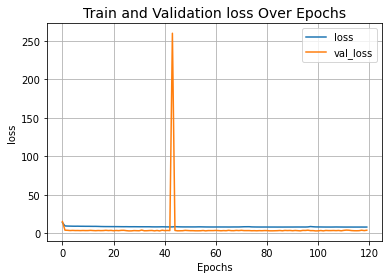

In [12]:

plot_result("loss")

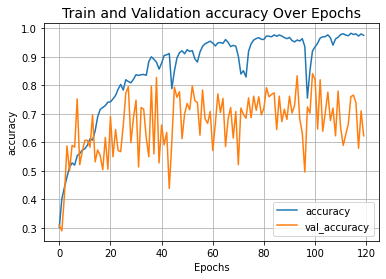

In [13]:
plot_result("accuracy")

In [14]:
validation_batch = next(iter(val_dataset))
val_predictions = segmentation_model.predict(validation_batch[0])
print(f"Validation prediction shape: {val_predictions.shape}")


1/1 [==============================] - 1s 719ms/step
Validation prediction shape: (21, 24, 6)


Index selected: 10


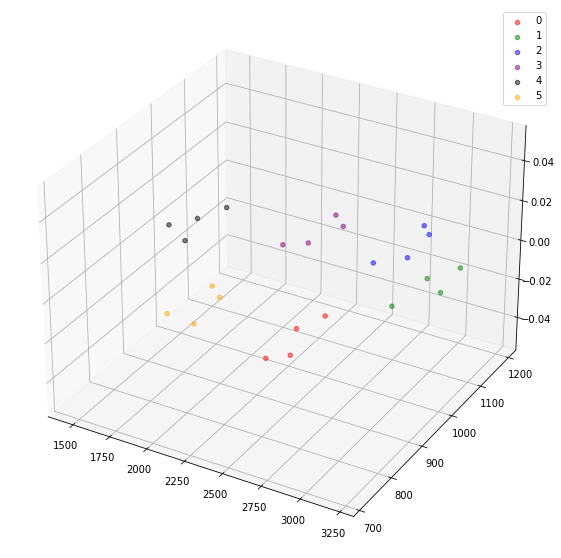

In [15]:
def visualize_single_point_cloud(point_clouds, label_clouds, idx):
    label_map = ['0', '1', '2', '3', '4', '5'] + ["none"]
    point_cloud = point_clouds[idx]
    label_cloud = label_clouds[idx]
    visualize_data(point_cloud, [label_map[np.argmax(label)] for label in label_cloud])


idx = np.random.choice(len(validation_batch[0]))
print(f"Index selected: {idx}")

# Plotting with ground-truth.
visualize_single_point_cloud(validation_batch[0], validation_batch[1], idx)


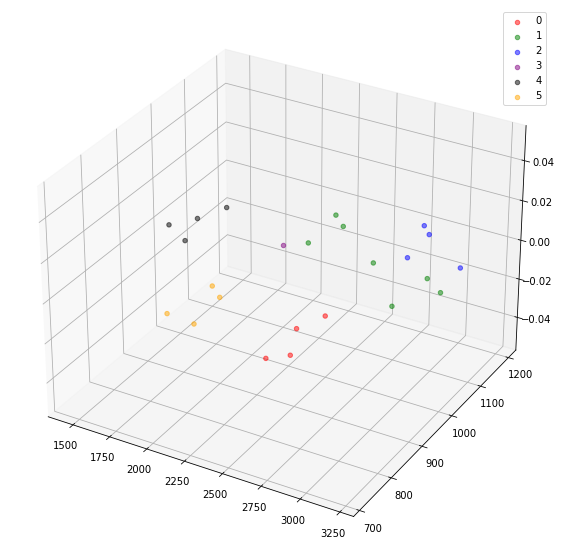

In [16]:

# Plotting with predicted labels.
visualize_single_point_cloud(validation_batch[0], val_predictions, idx)